<a href="https://colab.research.google.com/github/alexandre-a-marinho/PUCRio_MVP_sprint04_ATP_Predict/blob/main/predict_atp_tennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of the winning player in a tennis match

Original pre-processing Author: Ahlem JOUIDI

Modified by: Alexandre Alves Marinho

Extra-Processing Author: Alexandre Alves Marinho (see final sections)

The aim of this work is to explore data from ATP tennis competitions in order to predict the results of tennis matches.

## Import librairies

In [1]:
pip install scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import shap

# Load the data

In [4]:
# Informs URL to import the dataset
url = "https://raw.githubusercontent.com/alexandre-a-marinho/PUCRio_MVP_sprint04_ATP_Predict/main/api/ml_model/archive/atp_matches_till_2022.csv"

# Reads the source dataset
df = pd.read_csv(url, delimiter=',')
df.shape

(188161, 49)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188161 entries, 0 to 188160
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          188161 non-null  object 
 1   tourney_name        188161 non-null  object 
 2   surface             185844 non-null  object 
 3   draw_size           188161 non-null  int64  
 4   tourney_level       188161 non-null  object 
 5   tourney_date        188161 non-null  int64  
 6   match_num           188161 non-null  int64  
 7   winner_id           188161 non-null  int64  
 8   winner_seed         69694 non-null   float64
 9   winner_entry        16270 non-null   object 
 10  winner_name         188161 non-null  object 
 11  winner_hand         188144 non-null  object 
 12  winner_ht           171924 non-null  float64
 13  winner_ioc          188151 non-null  object 
 14  winner_age          186826 non-null  float64
 15  loser_id            188161 non-nul

In [6]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32,A,19680708,270,112411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32,A,19680708,271,126914,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32,A,19680708,272,209523,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-2029,Dublin,Grass,32,A,19680708,273,100084,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-2029,Dublin,Grass,32,A,19680708,274,100132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

# Exploratory Data Analysis

The objective of this analysis is to come up with insights regarding the tournaments using different types of visualizations as tools to facilitate interpretation of the data and variables and communication of the results.

Let's start with histograms to better understand the distribution of the key variables of our dataset based on multiple dimensions.

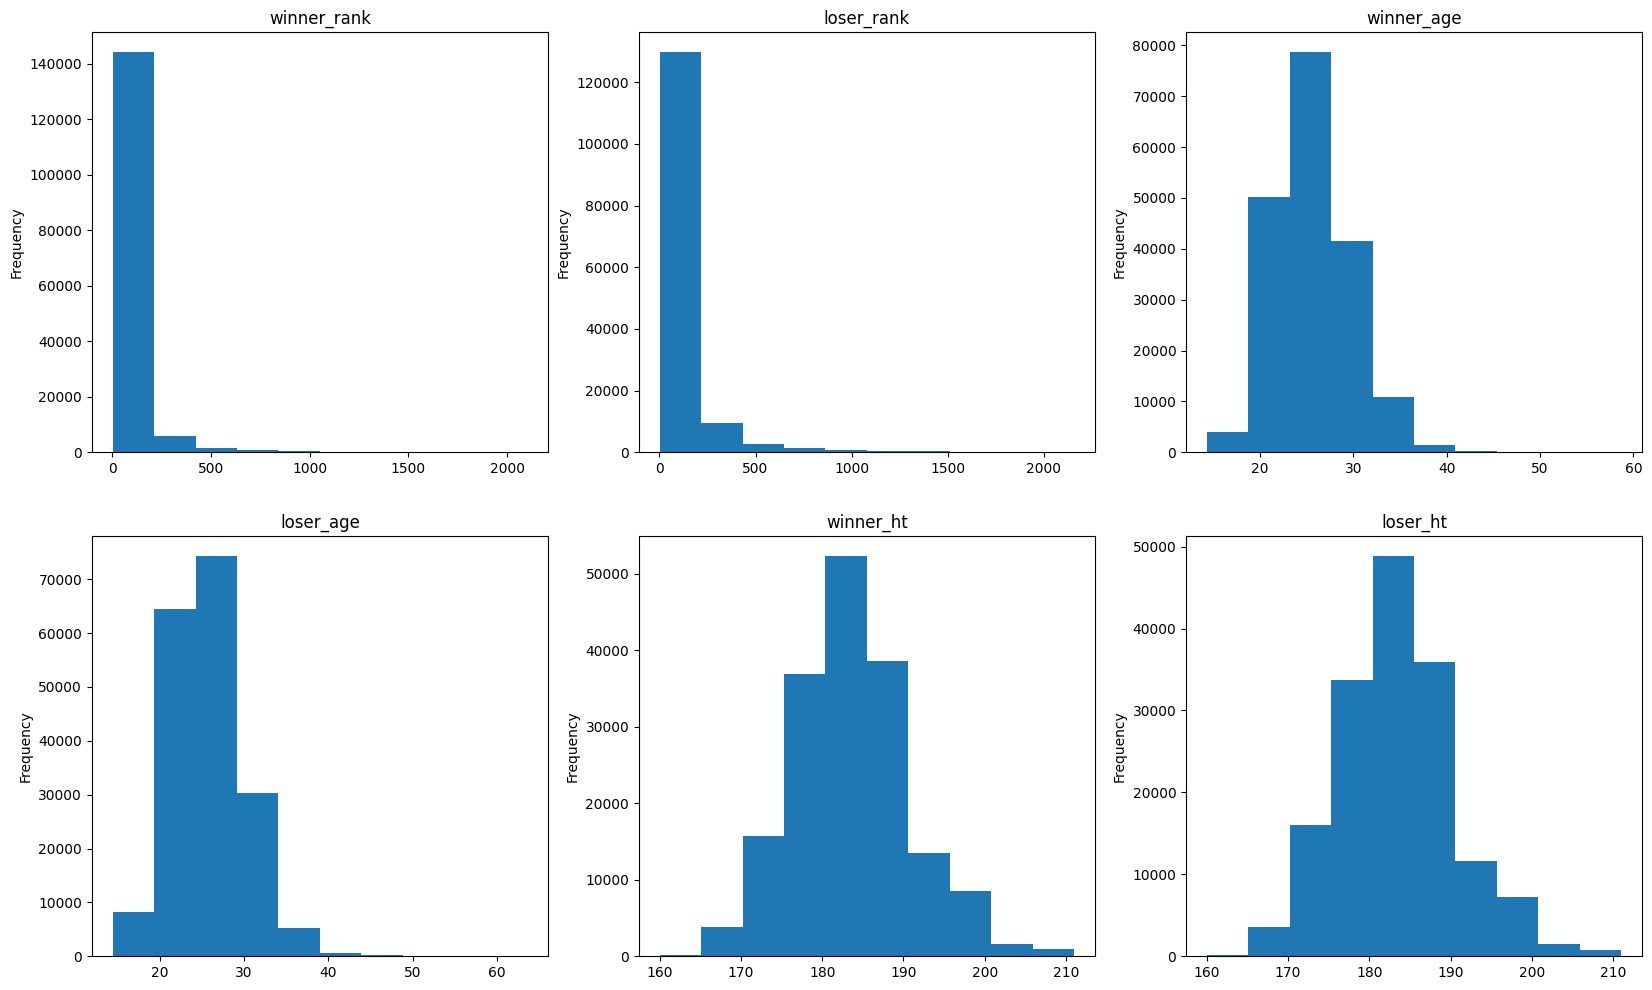

In [8]:
dimensions = ['winner_rank','loser_rank','winner_age','loser_age','winner_ht','loser_ht']

plt.figure(1, figsize=(20,12))

for i in range(1,7):
    plt.subplot(2,3,i)
    df[dimensions[i-1]].plot(kind='hist', title=dimensions[i-1])

Text(0.5, 1.0, '10 Top players')

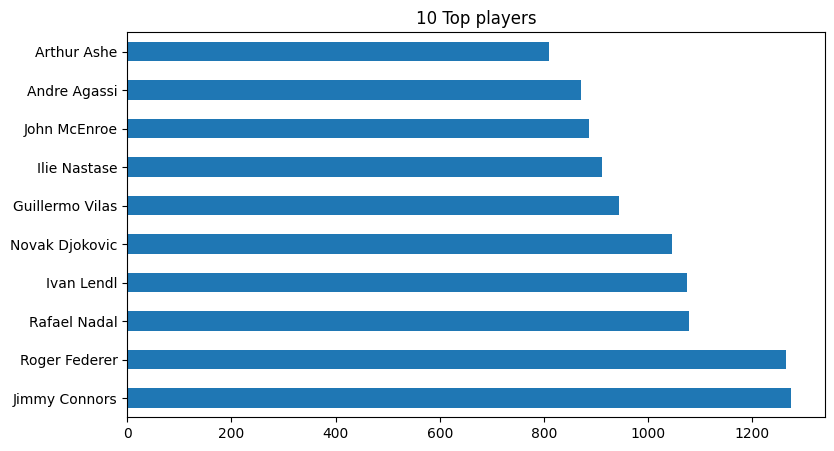

In [9]:
plt.figure(figsize=(9,5))
df['winner_name'].value_counts()[:10].plot(kind='barh')
plt.title('10 Top players')

The players who won the most matches are the likely to win again.

Let's now plot the correclation matrix and try to explore relations between features.

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

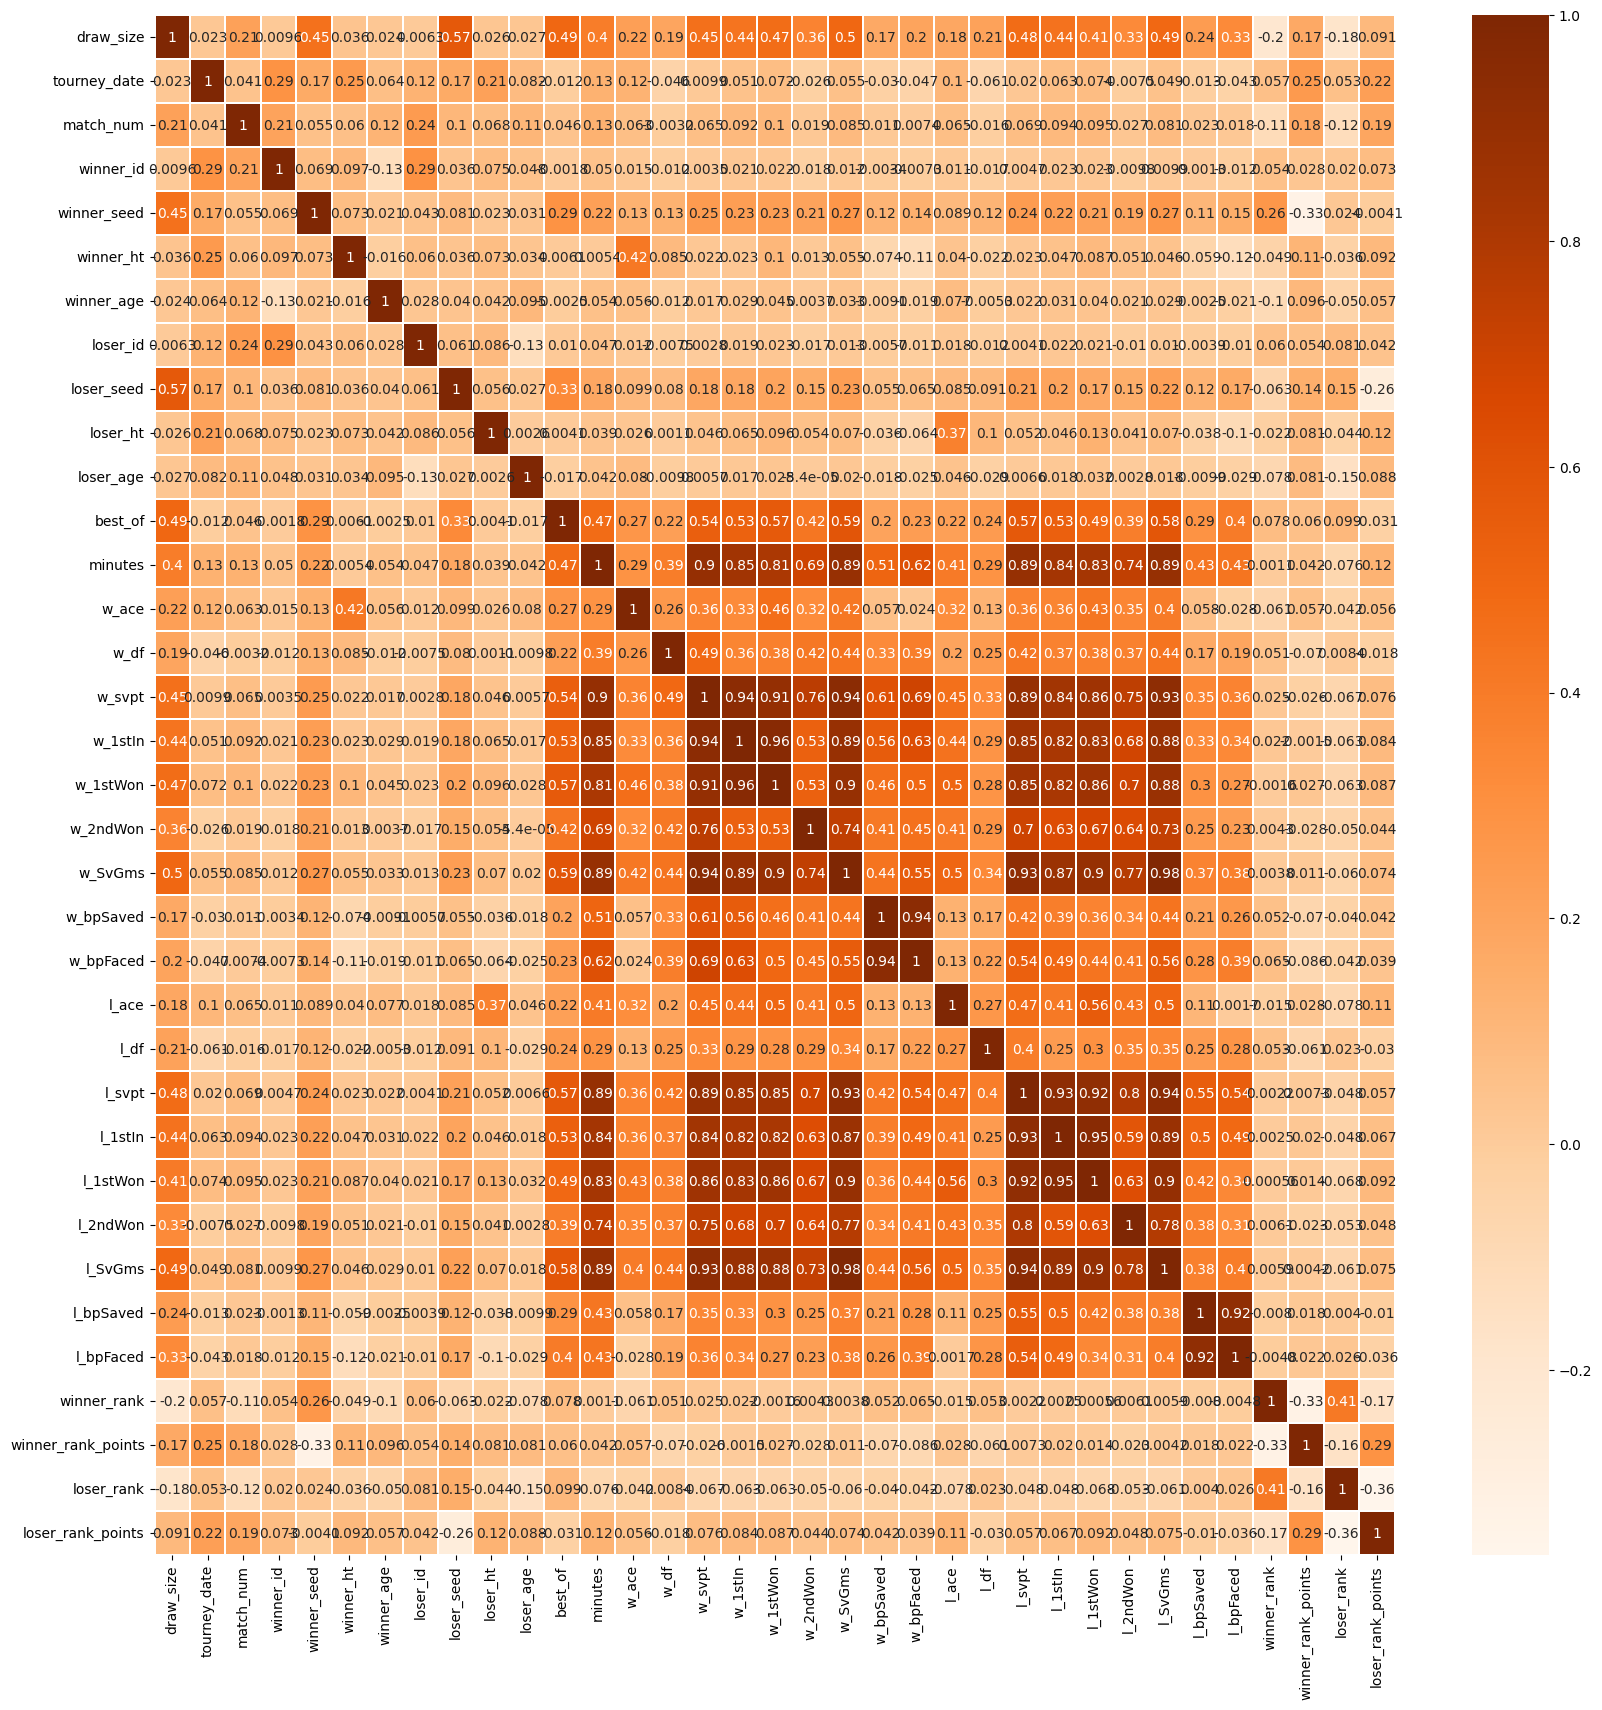

In [10]:
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot= True, linewidth=0.1, cmap= 'Oranges')

* We can see clearly that "minutes", "score", "1stIn", "_1stWon" ,"SvGms", "l_bpFaced", "l_bpSaved" and "svpt" features are highly correlated to each other. This is expected because they represent the result of a match.
* Features like rank, rank_points, age and ht are important ones.

# Preporcessing

As first step, let's clean the data and retain only important features for our prediction task.

We proceed to the removal of features that are redundant/ crrelated with each other, and those that are obviously not available before a match to predict.
* "winner_name", "loser_name" & "tourney_name" because they are almost redundant and replaceable by respectively "winner_id", "loser_id" & "tourney_id".

* "minutes", "score", "1stIn", "_1stWon" ,"SvGms", "l_bpFaced", "l_bpSaved", "svpt" features because cannot be known in advance.

In [11]:
df = df.drop(columns=['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'])
print("remained features ", df.columns)

remained features  Index(['tourney_id', 'surface', 'draw_size', 'tourney_level', 'tourney_date',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed',
       'loser_entry', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'best_of', 'round', 'winner_rank', 'winner_rank_points', 'loser_rank',
       'loser_rank_points'],
      dtype='object')


Let's now count the number and the percentage of None values in our data set and treat features and entries that contain a lot of them.

In [12]:
none_percent = df.isnull().sum() * 100 / len(df)
none_values_df = pd.DataFrame({'Feature name': df.columns, 'None values count': df.isnull().sum(),
                                 'None values percent': none_percent})
print(none_values_df.reset_index().drop(columns=['index']))

          Feature name  None values count  None values percent
0           tourney_id                  0             0.000000
1              surface               2317             1.231392
2            draw_size                  0             0.000000
3        tourney_level                  0             0.000000
4         tourney_date                  0             0.000000
5            match_num                  0             0.000000
6            winner_id                  0             0.000000
7          winner_seed             118467            62.960443
8         winner_entry             171891            91.353150
9          winner_hand                 17             0.009035
10           winner_ht              16237             8.629312
11          winner_ioc                 10             0.005315
12          winner_age               1335             0.709499
13            loser_id                  0             0.000000
14          loser_seed             152824            81

We can see that we have a lot of null values, so we have to handle them.

We will remove feature that have more than 85% of None values.

In [13]:
features_to_remove = none_values_df[none_values_df["None values percent"] > 85]
print(features_to_remove)
df = df.drop(columns=features_to_remove['Feature name'].values)

              Feature name  None values count  None values percent
winner_entry  winner_entry             171891            91.353150
loser_entry    loser_entry             160432            85.263152


Since "rank_points" and "rank", which contain past performance of players, and "surface" features are important ones, we will delete the entries that do not contain information about them.

In [14]:
df.dropna(subset=['winner_rank_points', 'loser_rank_points','winner_rank','loser_rank', 'surface'], inplace=True)
df = df.reset_index(drop=True)
df

,tourney_id,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_hand,winner_ht,...,loser_hand,loser_ht,loser_ioc,loser_age,best_of,round,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1973-303,Clay,32,A,19731125,5,100118,NaN,L,NaN,...,R,NaN,GRE,28.7,3,R32,54.0,0.0,110.0,0.0
1,1973-303,Clay,32,A,19731125,18,100035,NaN,R,185.0,...,R,180.0,CHI,29.4,3,R16,74.0,0.0,102.0,0.0
2,1973-303,Clay,32,A,19731125,19,100118,NaN,L,NaN,...,R,NaN,ARG,27.2,3,R16,54.0,0.0,149.0,0.0
3,1973-303,Clay,32,A,19731125,21,108421,NaN,R,NaN,...,R,NaN,FRA,26.8,3,R16,190.0,0.0,81.0,0.0
4,1973-303,Clay,32,A,19731125,22,100282,NaN,L,180.0,...,L,172.0,AUT,24.7,3,R16,33.0,0.0,85.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103584,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Clay,4,D,20220304,1,202120,NaN,R,NaN,...,R,193.0,CYP,25.7,3,RR,1390.0,4.0,402.0,98.0
103585,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Clay,4,D,20220304,2,209080,NaN,R,188.0,...,U,185.0,GRE,21.5,3,RR,1130.0,8.0,808.0,23.0
103586,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Clay,4,D,20220304,4,209362,NaN,R,NaN,...,R,188.0,USA,20.2,3,RR,1103.0,9.0,1130.0,8.0
103587,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Clay,4,D,20220304,5,202065,NaN,U,185.0,...,R,NaN,JAM,28.0,3,RR,808.0,23.0,1390.0,4.0


To avoid analytical errors, we will convert numerical values of string format to float type.

In [15]:
numeric_columns = ['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht']
df[numeric_columns] = df[numeric_columns].astype(float)

In [16]:
df.tourney_date

0         19731125
1         19731125
2         19731125
3         19731125
4         19731125
            ...   
103584    20220304
103585    20220304
103586    20220304
103587    20220304
103588    20220304
Name: tourney_date, Length: 103589, dtype: int64

We will expand the "tourney_date" feature to new columns storing year and month attributes.

In [17]:
#"tourney_date" is in the format of YYYYMMDD
df['tourney_year'] = df.tourney_date.astype(str).str[:4].astype(int)
df['tourney_month'] = df.tourney_date.astype(str).str[4:6].astype(int)
#Now drop "tourney_date"
df = df.drop(columns=['tourney_date'])

# Feature engineering ( =============== modified by Alexandre ==============)

For our supervised prediction model, we have to define our target feature!

We will transform our data so that we  have 2 players (first player & second player), their respective personal informations (id, hand, age, etc) and general informations about the match and the tourney.

Then we will create a column "label" which is equal to 1 if player 1 wins, 0 if player 2 wins.

To do so, we will create a first copy of our dataset where the loser is considered as first player so **label=0**. Then a second copy where we inverse the places of the players so **label=1**.

comment from Alexandre: the original text said "...where the *winner* considered...", but according to the description above and to the code below I believe the correct is "...where the *loser* considered..."


First copy of the data where the loser is considered as first player and the winner as second player

In [18]:
df = df.rename(columns={"loser_age": "first_age", "loser_entry": "first_entry", "loser_hand": "first_hand",
                        "loser_ht": "first_ht", "loser_id": "first_id", "loser_ioc": "first_ioc",
                        "loser_rank": "first_rank", "loser_rank_points": "first_rank_points",
                        "loser_seed": "first_seed",

                        "winner_age": "second_age", "winner_entry": "second_entry","winner_hand": "second_hand",
                        "winner_ht": "second_ht", "winner_id": "second_id", "winner_ioc": "second_ioc",
                        "winner_rank": "second_rank", "winner_rank_points": "second_rank_points",
                        "winner_seed": "second_seed",
                       },)

Create second copy with inverse of positions

In [19]:
copy_2_df = df.copy()
copy_2_df[[ 'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed',
            'second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed']]\
=copy_2_df[['second_age','second_hand','second_ht','second_id','second_ioc','second_rank','second_rank_points','second_seed',
             'first_age','first_hand','first_ht','first_id','first_ioc','first_rank','first_rank_points','first_seed']]


Construct label feature

In [20]:
winner_player2 = np.zeros(df.shape[0]) # second player wins so label=0
df['label'] = winner_player2


winner_player1 = np.ones(copy_2_df.shape[0]) # first player wins so label=1
copy_2_df['label'] = winner_player1

df = pd.concat([df,copy_2_df])
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)
df

,tourney_id,surface,draw_size,tourney_level,match_num,second_id,second_seed,second_hand,second_ht,second_ioc,...,first_age,best_of,round,second_rank,second_rank_points,first_rank,first_rank_points,tourney_year,tourney_month,label
0,2000-301,Hard,32,A,30,102796,2.0,R,188.0,SWE,...,21.0,3,SF,14.0,1498.0,72.0,553.0,2000,1,0.0
1,1997-560,Hard,128,G,87,102437,NaN,R,185.0,ROU,...,27.3,5,R64,107.0,423.0,63.0,775.0,1997,8,1.0
2,2019-6242,Hard,64,A,288,103852,16.0,L,188.0,ESP,...,22.5,3,R16,63.0,903.0,41.0,1078.0,2019,8,1.0
3,1995-418,Hard,56,A,44,101727,5.0,R,185.0,AUS,...,30.0,3,R16,28.0,1023.0,94.0,466.0,1995,7,0.0
4,1998-D080,Hard,4,D,1,101793,NaN,R,185.0,USA,...,24.1,5,RR,53.0,841.0,6.0,3027.0,1998,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207173,1997-421,Hard,56,M,7,101636,NaN,R,188.0,USA,...,23.7,3,R64,222.0,194.0,152.0,291.0,1997,7,1.0
207174,2010-747,Hard,32,A,18,104468,NaN,R,183.0,FRA,...,30.2,3,R16,43.0,1055.0,51.0,917.0,2010,10,0.0
207175,2009-533,Clay,32,A,21,104349,NaN,R,178.0,POR,...,22.8,3,R16,151.0,562.0,52.0,1342.0,2009,2,1.0
207176,1996-96,Hard,64,A,46,102882,NaN,R,196.0,AUS,...,22.6,3,R32,36.0,1040.0,168.0,239.0,1996,7,0.0


The problem with this method is that we have duplicated the dataset to be able to consider the two players in the two positions.

I tried another method where the idea was **to assign randomly** the winner and loser players to the first and second players features and if :
* winner player is assigned to player_1 and loser to player_2 then label=1 **
* winner player is assigned to player_2 and loser to player_1 then label=0 **

**comment by Alexandre: I think the logic was wrong up here, I had to change the labels for (1, 0), before it was (0, 1)

This method preserve the original size of data and enable as to create the label target. However after further work and execution of the classifiers we got overfitting problem. So we will keep the first method.

Below is the source code of this method.

In [21]:
# first_player = []
# second_player = []
# labels = []
# for winner, looser in zip(df['winner_id'], df['loser_id']):
#     number = np.random.choice([0,1],1)[0] #the number of the winner
#     if number == 0: #the winner is player 0 and the loser is player 1 => label = 0
#         first_player.append(winner)
#         second_player.append(looser)

#     else: #the loser is player 0 and the winner is player 1 => label = 1
#         second_player.append(winner)
#         first_player.append(looser)

#     labels.append(number)
# df['first_player_id'] = first_player
# df['second_player_id'] = second_player
# df['label'] = labels
# df = df.drop(columns=['loser_id', 'winner_id'])

# Comment from Alexandre: this code is confusing, he talks about player 1 and 2 and here the code says 0 and 1

### *** ==========  Modifications from Alexandre  ========== ***
For our prediction model, we have to encode categorical features. We will use LaberEncoder of Sklearn library.
I had o to add extra steps here do identify the encoding done here so that I can perform the same encoding on the data input from the user in the interface.
Obs: later on I learned I could use .pkl files for this par too, but I did not had enough time to implement it again, so it remained like this.

In [22]:
df['first_hand'].astype(str)

0         R
1         R
2         R
3         L
4         R
         ..
207173    L
207174    L
207175    R
207176    R
207177    L
Name: first_hand, Length: 207178, dtype: object

In [23]:
# AlexandreAM: encoding step by step to retrieve encoding info
hand_encoder = LabelEncoder()
hand_encoder.fit(df['first_hand'].astype(str))
classes = hand_encoder.classes_
print(classes);
print(hand_encoder.transform(classes));
df['first_hand'] = hand_encoder.transform(df['first_hand'].astype(str))
df['second_hand'] = hand_encoder.transform(df['second_hand'].astype(str))

# AlexandreAM: encoding step by step to retrieve encoding info
surface_encoder = LabelEncoder()
surface_encoder.fit(df['surface'].astype(str))
classes = surface_encoder.classes_
print(classes);
print(surface_encoder.transform(classes));
df['surface'] = surface_encoder.transform(df['surface'].astype(str))

# AlexandreAM: encoding step by step to retrieve encoding info
tourney_level_encoder = LabelEncoder()
tourney_level_encoder.fit(df['tourney_level'].astype(str))
classes = tourney_level_encoder.classes_
print(classes);
print(tourney_level_encoder.transform(classes));
df['tourney_level'] = tourney_level_encoder.transform(df['tourney_level'].astype(str))

# AlexandreAM: encoding step by step to retrieve encoding info
round_encoder = LabelEncoder()
round_encoder.fit(df['round'].astype(str))
classes = round_encoder.classes_
print(classes);
print(round_encoder.transform(classes));
df['round'] = round_encoder.transform(df['round'].astype(str))

# AlexandreAM: I don't use these fields at the end, so no modifications here
df['tourney_id'] = LabelEncoder().fit_transform(df['tourney_id'].astype(str))
df['first_ioc'] = LabelEncoder().fit_transform(df['first_ioc'].astype(str))
df['second_ioc'] = LabelEncoder().fit_transform(df['second_ioc'].astype(str))

df.info()

['L' 'R' 'U' 'nan']
[0 1 2 3]
['Carpet' 'Clay' 'Grass' 'Hard']
[0 1 2 3]
['A' 'D' 'F' 'G' 'M']
[0 1 2 3 4]
['BR' 'ER' 'F' 'QF' 'R128' 'R16' 'R32' 'R64' 'RR' 'SF']
[0 1 2 3 4 5 6 7 8 9]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207178 entries, 0 to 207177
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          207178 non-null  int64  
 1   surface             207178 non-null  int64  
 2   draw_size           207178 non-null  int64  
 3   tourney_level       207178 non-null  int64  
 4   match_num           207178 non-null  int64  
 5   second_id           207178 non-null  int64  
 6   second_seed         66071 non-null   float64
 7   second_hand         207178 non-null  int64  
 8   second_ht           202441 non-null  float64
 9   second_ioc          207178 non-null  int64  
 10  second_age          207092 non-null  float64
 11  first_id            207178 non-null  int64  
 12 

Finally, let's handle the few remaing None values using SimpleImputer.

In [24]:
df_imputed = pd.DataFrame(SimpleImputer().fit_transform(df))
df_imputed.columns = df.columns
df_imputed.index = df.index
df = df_imputed.copy()

In [25]:
print('Final shape of data after cleaning and preprocessing: ', df.shape)

Final shape of data after cleaning and preprocessing:  (207178, 26)


In [26]:
df.head()

,tourney_id,surface,draw_size,tourney_level,match_num,second_id,second_seed,second_hand,second_ht,second_ioc,...,first_age,best_of,round,second_rank,second_rank_points,first_rank,first_rank_points,tourney_year,tourney_month,label
0,1478.0,3.0,32.0,0.0,30.0,102796.0,2.000000,1.0,188.0,94.0,...,21.0,3.0,9.0,14.0,1498.0,72.0,553.0,2000.0,1.0,0.0
1,1101.0,3.0,128.0,3.0,87.0,102437.0,7.359386,1.0,185.0,83.0,...,27.3,5.0,7.0,107.0,423.0,63.0,775.0,1997.0,8.0,1.0
2,4166.0,3.0,64.0,0.0,288.0,103852.0,16.000000,0.0,188.0,32.0,...,22.5,3.0,5.0,63.0,903.0,41.0,1078.0,2019.0,8.0,1.0
3,779.0,3.0,56.0,0.0,44.0,101727.0,5.000000,1.0,185.0,5.0,...,30.0,3.0,5.0,28.0,1023.0,94.0,466.0,1995.0,7.0,0.0
4,1334.0,3.0,4.0,1.0,1.0,101793.0,7.359386,1.0,185.0,105.0,...,24.1,5.0,8.0,53.0,841.0,6.0,3027.0,1998.0,4.0,1.0


# Prediction model

### Dataset Holdout
Let's now train and execute our prediction model. For this we will use 2 differents models : RandomForest and XGBoost.

In [27]:
y = df['label']
df_X = df.drop(columns='label')

In [28]:
# split data : 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.2)

### RandomForest classifier

Random Forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.


In [29]:
#Call the classifier
RF_classifier = RandomForestClassifier(n_estimators=100)
#fit the data
RF_classifier.fit(X_train, y_train)
#predict
RF_predictions = RF_classifier.predict(X_test)

In [30]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[13638  7146]
 [ 7553 13099]]
Classification report
              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65     20784
         1.0       0.65      0.63      0.64     20652

    accuracy                           0.65     41436
   macro avg       0.65      0.65      0.65     41436
weighted avg       0.65      0.65      0.65     41436

Accuracy=  0.6452601602471281


### XGBoost classifier

Like Random Forests,  Extreme Gradient Boosting is a set of decision trees. The two main differences are:

**How trees are built:** random forests builds each tree independently while gradient boosting builds one tree at a time. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners.
**Combining results:** random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.

In [31]:
#Call the classifier
XGB_classifier = XGBClassifier(learning_rate=0.2, n_estimators=100, max_depth=3)
#fit the data
XGB_classifier.fit(X_train, y_train)
#predict
XGB_predictions = XGB_classifier.predict(X_test)

In [32]:
print('Confusion matrix')
print(confusion_matrix(y_test,XGB_predictions))
print('Classification report')
print(classification_report(y_test,XGB_predictions))
print('Accuracy= ', accuracy_score(y_test, XGB_predictions))

Confusion matrix
[[13740  7044]
 [ 7044 13608]]
Classification report
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     20784
         1.0       0.66      0.66      0.66     20652

    accuracy                           0.66     41436
   macro avg       0.66      0.66      0.66     41436
weighted avg       0.66      0.66      0.66     41436

Accuracy=  0.6600057920648711


XGBoost gives slightly better results than RandomForest.

## Feature importance

We will use SHAP (SHapley Additive exPlanations) library which is a game theoretic approach to explain the output of any machine learning model. It will allow as visualize the behaviour of the classifer as well as the most important features used.

We will visualize the output of XGBoost model.

[01:14:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


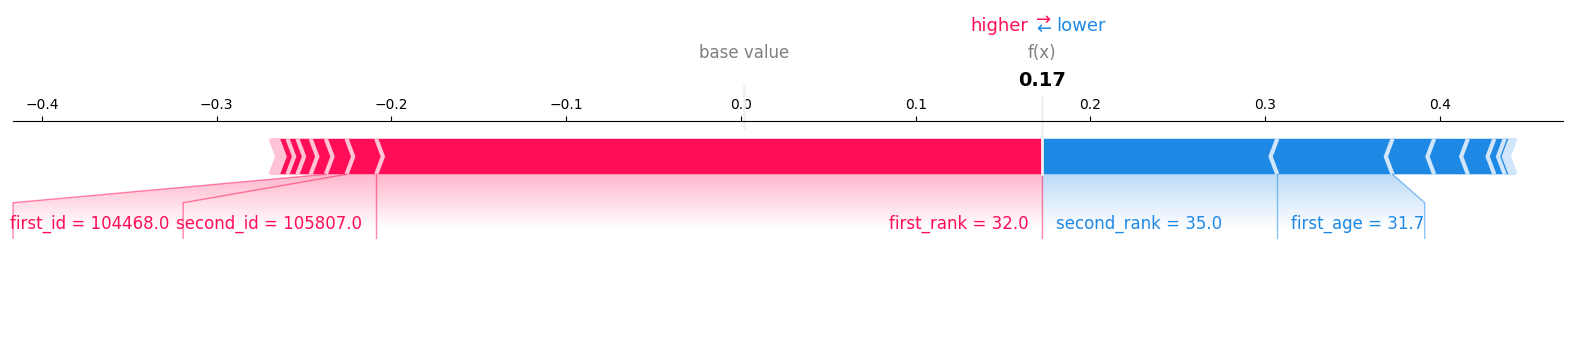

In [33]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(XGB_classifier)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

In [34]:
type(shap_values)

numpy.ndarray

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

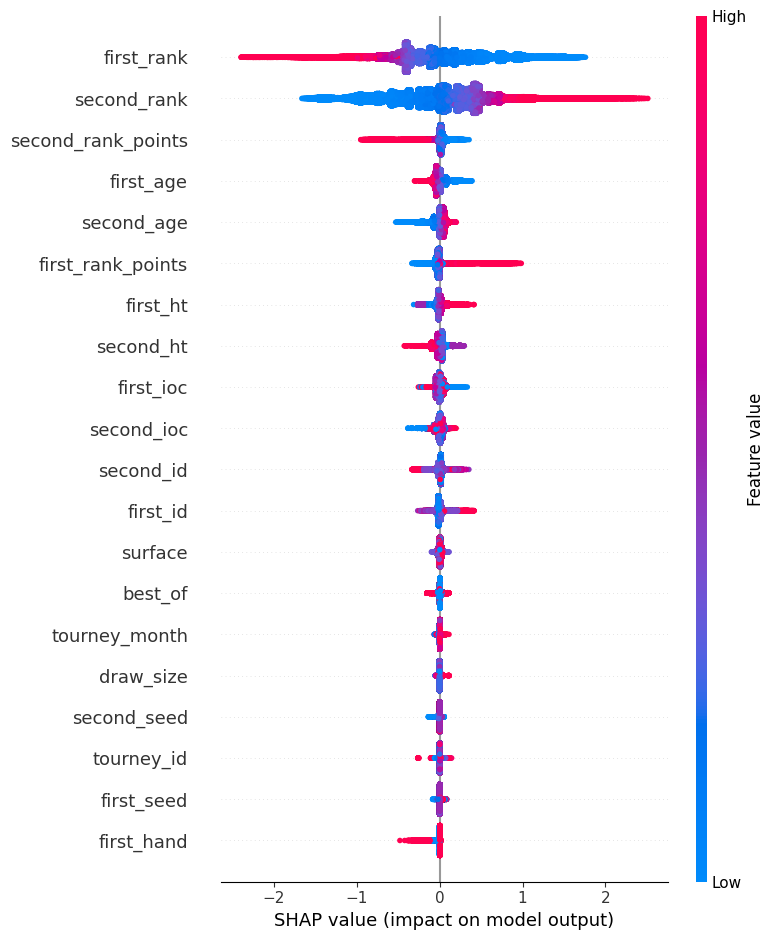

In [35]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

This plot allow us to get an overview of which features are most important for a model. "First_rank", "second_rank", "first_rank_points" and "second_rank_points" are the most important features. This is expected as those features express directly the level of performance of each player.

The color represents the feature value (red high, blue low). This reveals for example that a high first_rank (rank of first player) should lower the predicted labels (label tends vers 0).

# Further work

With more time we can:
* Make more in-depth cleaning of the data and more accurate feature engineering.
* Fine tune the hyperparameters of the classifiers in order to improve the quality of prediction.
*  Use Time Series to  better exploit the time features.
*  We could suggest making predictions during the match by including information about the current situation (number of minutes spent, number of faults, ect.).

Time needed to finish this test: about 6 hours.

  *==================================================================================================*
# *========== ADDITIONS BY ALEXANDRE | MVP-04 PUC-Rio ==========*
  *==================================================================================================*

## Extra Pre-Processing

**1. Removing unrelevant data**

We are going to drop more columns to simplify the model. They are not result relevant and we can make it easier for the user to fill up the input data in the front-end.

In [36]:
df = df.drop(columns=['tourney_id','draw_size','match_num','second_seed','second_ioc','first_seed','first_ioc','tourney_month'])
df.head()

,surface,tourney_level,second_id,second_hand,second_ht,second_age,first_id,first_hand,first_ht,first_age,best_of,round,second_rank,second_rank_points,first_rank,first_rank_points,tourney_year,label
0,3.0,0.0,102796.0,1.0,188.0,23.6,103292.0,1.0,175.0,21.0,3.0,9.0,14.0,1498.0,72.0,553.0,2000.0,0.0
1,3.0,3.0,102437.0,1.0,185.0,23.0,101736.0,1.0,180.0,27.3,5.0,7.0,107.0,423.0,63.0,775.0,1997.0,1.0
2,3.0,0.0,103852.0,0.0,188.0,37.9,128034.0,1.0,196.0,22.5,3.0,5.0,63.0,903.0,41.0,1078.0,2019.0,1.0
3,3.0,0.0,101727.0,1.0,185.0,25.2,101150.0,0.0,180.0,30.0,3.0,5.0,28.0,1023.0,94.0,466.0,1995.0,0.0
4,3.0,1.0,101793.0,1.0,185.0,27.6,102338.0,1.0,190.0,24.1,5.0,8.0,53.0,841.0,6.0,3027.0,1998.0,1.0


In [37]:
df.shape

(207178, 18)

In [38]:
df.columns.tolist()

['surface',
 'tourney_level',
 'second_id',
 'second_hand',
 'second_ht',
 'second_age',
 'first_id',
 'first_hand',
 'first_ht',
 'first_age',
 'best_of',
 'round',
 'second_rank',
 'second_rank_points',
 'first_rank',
 'first_rank_points',
 'tourney_year',
 'label']

**2. Focusing on recent periods**

Game style changed a lot from decade to decade since 1968, so we must focus on shorter time periods to get more precise results. Let's use only the last 10 years of available data.

We don't need an ML model to tell us that a top player will most probably beat a player out of the top 100. As we can see from the original author analysis, the player rank is dominating the influence over the ML model and I believe this can be hiding other aspects which would be much more relevant when trying to predict matches between the top players during final stages of big tournaments, which are actually the difficult ones to predict.

Therefore, we will now use only matches between top 32 players

In [39]:
first_year = 2013
last_year = 2022
df = df[(df['tourney_year'] >= first_year) & (df['tourney_year'] <= last_year)]

rank_cutoff = 32.0
df = df[(df['first_rank'] <= rank_cutoff) & (df['second_rank'] <= rank_cutoff)]

print(df.shape)
df.head()

(6526, 18)


,surface,tourney_level,second_id,second_hand,second_ht,second_age,first_id,first_hand,first_ht,first_age,best_of,round,second_rank,second_rank_points,first_rank,first_rank_points,tourney_year,label
10,3.0,4.0,104755.0,1.0,185.0,28.1,103333.0,1.0,208.0,35.4,3.0,6.0,13.0,2460.0,31.0,1205.0,2014.0,0.0
58,3.0,0.0,106043.0,1.0,170.0,27.3,106432.0,1.0,188.0,23.1,3.0,8.0,13.0,2125.0,28.0,1415.0,2020.0,0.0
79,3.0,4.0,104607.0,1.0,196.0,29.1,105683.0,1.0,196.0,23.8,3.0,9.0,5.0,4485.0,10.0,3930.0,2014.0,1.0
142,3.0,0.0,106298.0,1.0,185.0,23.6,104755.0,1.0,185.0,31.3,3.0,3.0,25.0,1780.0,32.0,1375.0,2017.0,0.0
148,3.0,3.0,106233.0,1.0,185.0,24.9,104731.0,1.0,203.0,32.2,5.0,5.0,9.0,3485.0,5.0,4615.0,2018.0,0.0


## Prediction model (holdout + trasnformations + initial analysis)

### Data Holdout

In [40]:
y = df['label']
df_X = df.drop(columns='label')

In [41]:
# Split data : 80% for train and 20% for test.
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.2)


### Data Transformation

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Applying standard scaler to the dataset
scaler_std = StandardScaler().fit(X_train)
X_train_scaled = scaler_std.transform(X_train)
X_test_scaled = scaler_std.transform(X_test)

### RandomForest classifier (simple test)

Random Forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.


In [43]:
# Create classifier
#RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt' , n_estimators=800)  # checking back after tunning
# Fit the data
RF_classifier.fit(X_train_scaled, y_train)
# Predict
RF_predictions = RF_classifier.predict(X_test_scaled)

In [44]:
print('Confusion matrix')
print(confusion_matrix(y_test,RF_predictions))
print('Classification report')
print(classification_report(y_test,RF_predictions))
print('Accuracy= ', accuracy_score(y_test, RF_predictions))

Confusion matrix
[[384 248]
 [232 442]]
Classification report
              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62       632
         1.0       0.64      0.66      0.65       674

    accuracy                           0.63      1306
   macro avg       0.63      0.63      0.63      1306
weighted avg       0.63      0.63      0.63      1306

Accuracy=  0.6324655436447167


### XGBoost classifier (simple test)

Like Random Forests,  Extreme Gradient Boosting is a set of decision trees. The two main differences are:

**How trees are built:** random forests builds each tree independently while gradient boosting builds one tree at a time. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners.
**Combining results:** random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.

In [45]:
# Create the classifier
#XGB_classifier = XGBClassifier()
XGB_classifier = XGBClassifier(learning_rate=0.2, n_estimators=100, max_depth=3)   # checking back after tunning
# Fit the data
XGB_classifier.fit(X_train_scaled, y_train)
# Predict
XGB_predictions = XGB_classifier.predict(X_test_scaled)

In [46]:
print('Confusion matrix')
print(confusion_matrix(y_test,XGB_predictions))
print('Classification report')
print(classification_report(y_test,XGB_predictions))
print('Accuracy= ', accuracy_score(y_test, XGB_predictions))

Confusion matrix
[[396 236]
 [241 433]]
Classification report
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62       632
         1.0       0.65      0.64      0.64       674

    accuracy                           0.63      1306
   macro avg       0.63      0.63      0.63      1306
weighted avg       0.63      0.63      0.63      1306

Accuracy=  0.6347626339969372


## Feature importance

We will use SHAP (SHapley Additive exPlanations) library which is a game theoretic approach to explain the output of any machine learning model. It will allow as visualize the behaviour of the classifer as well as the most important features used.\

### We will visualize the output of XGBoost model.

[01:15:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


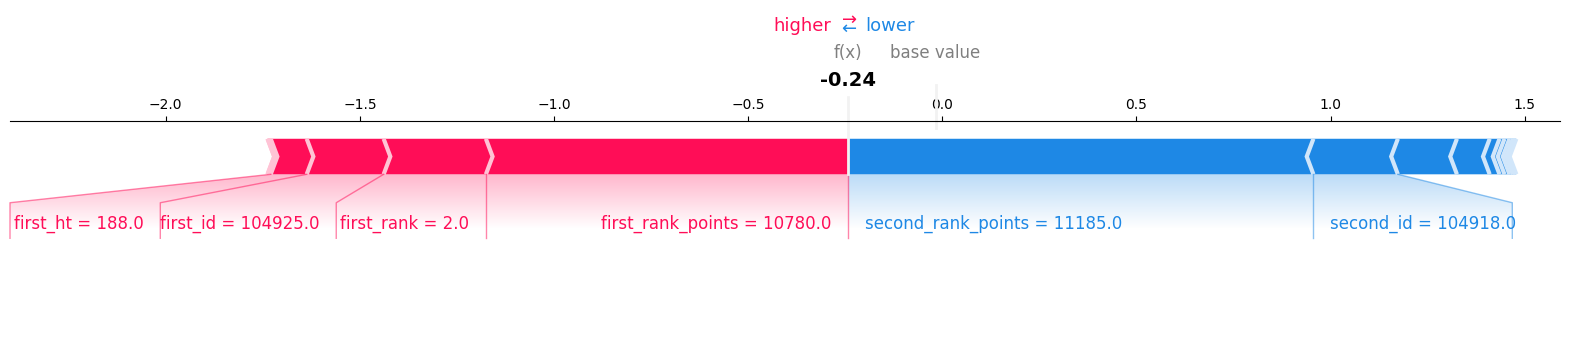

In [47]:
# Load JS visualization code to notebook
shap.initjs()

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(XGB_classifier)
shap_values = explainer.shap_values(X_train_scaled)

# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], matplotlib=True)

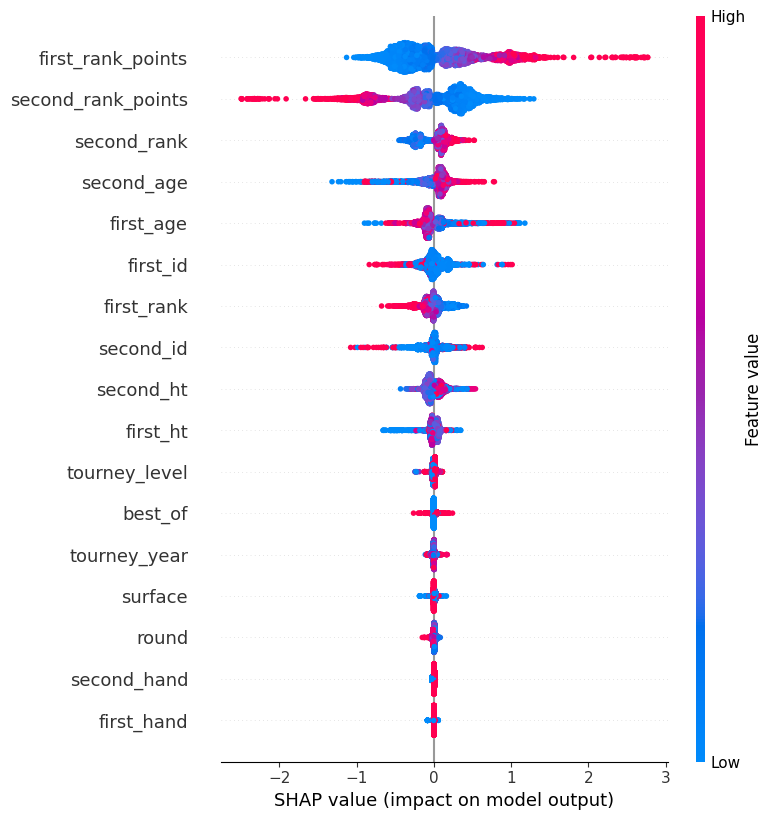

In [48]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

## Pipelines to compare performance of different Predicition Models

KNN-orig: 0.634 (0.017)
CART-orig: 0.585 (0.024)
NB-orig: 0.661 (0.012)
XGB-orig: 0.647 (0.021)
RFC-orig: 0.644 (0.013)
KNN-std: 0.616 (0.017)
CART-std: 0.575 (0.025)
NB-std: 0.656 (0.011)
XGB-std: 0.647 (0.021)
RFC-std: 0.643 (0.014)
KNN-norm: 0.612 (0.013)
CART-norm: 0.584 (0.025)
NB-norm: 0.656 (0.011)
XGB-norm: 0.647 (0.021)
RFC-norm: 0.645 (0.016)


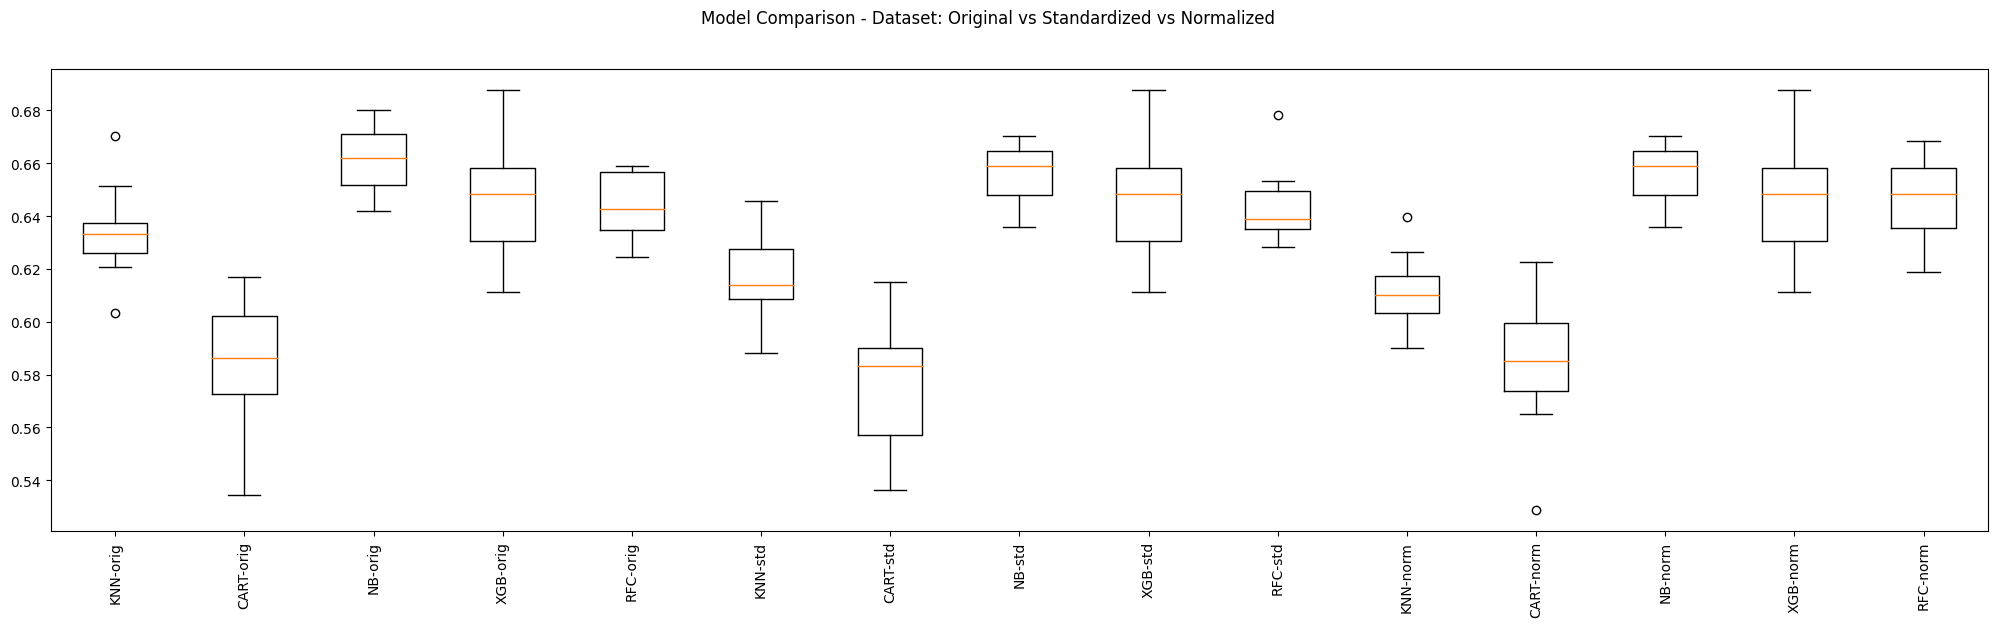

In [49]:
# Global seed for this code block
np.random.seed(7)

# Cross-validation parameters
seed = 7
scoring = 'accuracy'

# Creates k partitions, treains with k-1 partitions and tests with the one remaining, repeat until all partitions are used as test data
nb_partitions = 10
kfold = StratifiedKFold(n_splits=nb_partitions, shuffle=True, random_state=seed)

# Lists to store pipelines and results of the dataset analysis
pipelines = []
results = []
names = []

# Pipeline algorithms
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
xgb = ('XGB', XGBClassifier())
rfc = ('RFC', RandomForestClassifier(n_estimators=100))

# Pipeline data transformation/standardization
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Obs: SVM was taking too long to complete, so after I decided to focus on XGB and RFC I commented SVM pipelines
# Pipeline 1 - Original dataset
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
# pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('XGB-orig', Pipeline([xgb])))
pipelines.append(('RFC-orig', Pipeline([rfc])))

# Pipeline 2 - Original dataset (stanbdardized)
pipelines.append(('KNN-std', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-std', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-std', Pipeline([standard_scaler, naive_bayes])))
# pipelines.append(('SVM-std', Pipeline([standard_scaler, svm])))
pipelines.append(('XGB-std', Pipeline([standard_scaler, xgb])))
pipelines.append(('RFC-std', Pipeline([standard_scaler, rfc])))

# Pipeline 3 - Original dataset (normalized)
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
# pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('XGB-norm', Pipeline([min_max_scaler, xgb])))
pipelines.append(('RFC-norm', Pipeline([min_max_scaler, rfc])))

# Executing Pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot to compare model performance
fig = plt.figure(figsize=(25,6))
fig.suptitle('Model Comparison - Dataset: Original vs Standardized vs Normalized')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Hyperparameter Optimization

In [50]:
# Model Tunning
np.random.seed(7)
pipelines = []

# Defines Pipelines
svm = ('SVM', SVC())
xgb = ('XGB', XGBClassifier())
rfc = ('RFC', RandomForestClassifier())
naive_bayes = ('NB', GaussianNB())

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Please uncomment pipeline that you want to test (they have different models and it
# takes too much time to test all of them using GridSearchCV, so it's more
# manageable like this)

# pipelines.append(('SVM-orig', Pipeline(steps=[svm])))
# pipelines.append(('SVM-std', Pipeline(steps=[standard_scaler, svm])))
# pipelines.append(('SVM-norm', Pipeline(steps=[min_max_scaler, svm])))
# pipelines.append(('XGB-std', Pipeline(steps=[standard_scaler, xgb])))
# pipelines.append(('NB-orig', Pipeline(steps=[naive_bayes])))
# pipelines.append(('RFC-std', Pipeline(steps=[standard_scaler, rfc])))
pipelines.append(('XGB-std', Pipeline(steps=[standard_scaler, xgb])))

# Param_grids - uncomment set of params that you want to test (according to pipeline model)

# XGB Hyperparameter variation =================================================
param_grid = {
    'XGB__learning_rate': [0.01, 0.1, 0.2],
    'XGB__n_estimators': [50, 100, 200],
    'XGB__max_depth': [3, 5, 7],
}

# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 1.0],
#     'min_child_weight': [1, 3, 5]
# }


# RFC Hyperparameter variation =================================================
# param_grid = {'RFC__bootstrap': [True, False],
#               'RFC__max_depth': [10, 20],
#               'RFC__max_features': ['log2', 'sqrt'],
#               'RFC__n_estimators': [400, 800]}

# param_grid = {'RFC__bootstrap': [True, False],
#               'RFC__max_depth': [10, 20, 30],
#               'RFC__max_features': ['log2', 'sqrt'],
#               'RFC__n_estimators': [200, 400, 600, 800]}

# param_grid = {'RFC__bootstrap': [True, False],
#               'RFC__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'RFC__max_features': ['auto', 'sqrt'],
#               'RFC__min_samples_leaf': [1, 2, 4],
#               'RFC__min_samples_split': [2, 5, 10],
#               'RFC__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# NB Hyperparameter variation ==================================================
# param_grid = {
#     'NB__alpha': [0.1, 0.5, 1.0],
#     'NB__binarize': [0.0, 0.1, 0.5]
# }


# SVM Hyperparameter variation =================================================
# param_grid = {
#     'SVM__C': [0.1, 1, 10],
#     'SVM__gamma': [1, 0.1, 0.01],
#     'SVM__kernel': ['poly', 'linear']
# }

# param_grid = {
#     'SVM__C': [1, 10],
#     'SVM__kernel': ['linear'],
#     'SVM__gamma': [0.1, 1]
# }

# param_grid = {
#     'SVM__C': [0.1, 1, 10, 100, 1000],
#     'SVM__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#     'SVM__kernel': ['rbf', 'poly', 'sigmoid', 'linear']
# }


# Prepare and executes GridSearchCV ============================================
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # prints the best configuration
    print("No missings treatment: %s - Best: %f using: %s" % (name, grid.best_score_, grid.best_params_))

No missings treatment: XGB-std - Best: 0.669540 using: {'XGB__learning_rate': 0.1, 'XGB__max_depth': 3, 'XGB__n_estimators': 50}


## Generate and Download Final ATP Prediction Model and Data Transformation objects

In [51]:
from pickle import dump
from pickle import load
from google.colab import files

# Scaler download ==============================================================
# Creating normalized scaler
scaler_std = StandardScaler().fit(X_train)
X_train_scaled_final = scaler_std.transform(X_train)

# Saves scaler in disk
scaler_filename = 'atp_scaler.pkl'
dump(scaler_std, open(scaler_filename, 'wb'))

# Download the scaler file to your local machine
files.download(scaler_filename)

# Model download ===============================================================
# Creating model with optimized parameters
# final_model = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt' , n_estimators=400)  # 0.654789 (without data transformation)
# final_model = GaussianNB()  # 0.652
# final_model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=3)  # 0.663027 (without data transformation)
# final_model = XGBClassifier(learning_rate=0.2, n_estimators=100, max_depth=3)  # 0.662644 (without data transformation)
# final_model = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='sqrt' , n_estimators=800)  # 0.657280 (with std data transformation)
final_model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=3)  # 0.665900 (with std data transformation)

final_model.fit(X_train_scaled_final, y_train)
# Saves model in disk
model_filename = 'atp_model.pkl'
dump(final_model, open(model_filename, 'wb'))

# Download the model file to your local machine
files.download(model_filename)

# Golden Data export ===========================================================
df_test_golden = pd.concat([X_test, y_test], axis=1)
golden_file_path = 'matches_golden.csv'
df_test_golden.to_csv(golden_file_path)
files.download(golden_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>